In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI SDK for Python: AutoML tabular training and prediction

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/automl-tabular-classification.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Fautoml%2Fautoml-tabular-classification.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/automl-tabular-classification.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/automl/automl-tabular-classification.ipynb" target='_blank'>
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
     </a>
   </td>
</table>
<br/><br/><br/>

## Overview

This tutorial demonstrates how to use the Vertex AI Python client library to train and deploy a tabular classification model for online prediction.

**Note**: you may incur charges for training, prediction, storage, or usage of other Google Cloud products in connection with testing this SDK.

Learn more about [Classification for tabular data](https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/overview).

### Objective

In this tutorial, you learn how to train and make predictions on an AutoML model based on a tabular dataset. Alternatively, you can train and make predictions on models by using the `gcloud` command-line tool or by using the Google Cloud Console.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI
- AutoML Tabular

The steps performed include the following:

- Create a Vertex AI model training job.
- Train an AutoML Tabular model.
- Deploy the model resource to a serving endpoint resource.
- Make a prediction by sending data.
- Undeploy the model resource.

### Dataset

The dataset we are using is the PetFinder Dataset, available locally in Colab. To learn more about this dataset, visit https://www.kaggle.com/c/petfinder-adoption-prediction.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and
[Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the
[Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installation

Install the packages required for executing this notebook.

In [3]:
# 현재 설치된 파이썬 패키지 리스트를 확인
# !pip list

In [2]:
# Install the packages
! pip3 install --quiet --upgrade google-cloud-aiplatform \
                                 google-cloud-storage

### Restart runtime (Colab only)
To use the newly installed packages, you must restart the runtime on Google Colab.

In [4]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">,
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>,
</div>

### Authenticate your notebook environment (Colab only)
Authenticate your environment on Google Colab.

In [3]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information
To get started using Vertex AI, you must have an existing Google Cloud project. Learn more about [setting up a project and a development environment.](https://cloud.google.com/vertex-ai/docs/start/cloud-environment)

In [4]:
PROJECT_ID = "automl-tabular-phj"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [9]:
# 버킷의 이름 지정
BUCKET_URI = (
    f"gs://colab-bucket-phj"  # @param {type:"string"}
)

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [6]:
# 지정된 버킷 이름으로 버킷 생성
#! gsutil mb -l $LOCATION $BUCKET_URI

Creating gs://colab-bucket-phj-automl-tabular-phj-unique/...
You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.


### Copy dataset into your Cloud Storage bucket

In [12]:
#IMPORT_FILE = "petfinder-tabular-classification.csv"
#! gsutil cp gs://cloud-samples-data/ai-platform-unified/datasets/tabular/{IMPORT_FILE} {BUCKET_URI}/data/
# gs://colab-bucket-phj/train.csv
gcs_source = f"gs://colab-bucket-phj/train.csv"

### Import Vertex AI SDK for Python

Import the Vertex AI SDK into your Python environment and initialize it.

In [10]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION)

## Tutorial

Now you're ready to create your AutoML Tabular model.

### Create a Managed tabular dataset from a CSV

This section creates a dataset from a CSV file stored on your GCS bucket.

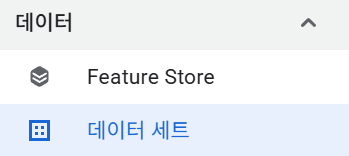

In [13]:
# Vertex AI의 데이터세트를 수행
ds = dataset = aiplatform.TabularDataset.create(
    display_name="petfinder-tabular-dataset",
    gcs_source=gcs_source,
)

ds.resource_name

'projects/791614448068/locations/us-central1/datasets/327802349391183872'

### Launch a training job to create a model

Once you've defined your training script, you'll create a model. The `run` function creates a training pipeline that trains and creates a model object. After the training pipeline completes, the `run` function returns the model object.

In [ ]:
job = aiplatform.AutoMLTabularTrainingJob(
    display_name="train-petfinder-automl-1",
    optimization_prediction_type="classification",
    column_transformations=[
        {"categorical": {"column_name": "Type"}},
        {"numeric": {"column_name": "Age"}},
        {"categorical": {"column_name": "Breed1"}},
        {"categorical": {"column_name": "Color1"}},
        {"categorical": {"column_name": "Color2"}},
        {"categorical": {"column_name": "MaturitySize"}},
        {"categorical": {"column_name": "FurLength"}},
        {"categorical": {"column_name": "Vaccinated"}},
        {"categorical": {"column_name": "Sterilized"}},
        {"categorical": {"column_name": "Health"}},
        {"numeric": {"column_name": "Fee"}},
        {"numeric": {"column_name": "PhotoAmt"}},
    ],
)

# This takes about an hour to run
model = job.run(
    dataset=ds,
    target_column="AdoptionSpeed",
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    model_display_name="adopted-prediction-model",
    disable_early_stopping=False,
)

### Deploy your model

Before you use your model to make predictions, you need to deploy it to an endpoint. You can do this by calling the `deploy` function on the model resource. This function does two things:

1. Creates an endpoint resource to which the model resource is deployed.
2. Deploys the model resource to the endpoint resource.

Deploy your model.

### NOTE: Wait until the model **FINISHES** deployment before proceeding to prediction.

In [ ]:
endpoint = model.deploy(
    machine_type="n1-standard-4",
)

### Predict on the endpoint


* This sample instance is taken from an observation in which `Adopted` = **Yes**
* Note that the values are all strings. Since the original data was in CSV format, everything is treated as a string. The transformations you defined when creating your `AutoMLTabularTrainingJob` inform Vertex AI to transform the inputs to their defined types.


In [ ]:
prediction = endpoint.predict(
    [
        {
            "Type": "Cat",
            "Age": "3",
            "Breed1": "Tabby",
            "Gender": "Male",
            "Color1": "Black",
            "Color2": "White",
            "MaturitySize": "Small",
            "FurLength": "Short",
            "Vaccinated": "No",
            "Sterilized": "No",
            "Health": "Healthy",
            "Fee": "100",
            "PhotoAmt": "2",
        }
    ]
)

print(prediction)

### Undeploy the model

To undeploy your model resource from the serving endpoint resource, use the endpoint's `undeploy` method with the following parameter:

- `deployed_model_id`: The model deployment identifier returned by the prediction service when the model resource is deployed. You can retrieve the `deployed_model_id` using the prediction object's `deployed_model_id` property.

In [ ]:
endpoint.undeploy(deployed_model_id=prediction.deployed_model_id)

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Training Job
- Model
- Endpoint
- Cloud Storage Bucket

**Note**: You must delete any model resources deployed to the endpoint resource before deleting the endpoint resource.

In [ ]:
# Warning: Setting this to true will delete everything in your bucket
delete_bucket = False

# Delete the training job
job.delete()

# Delete the model
model.delete()

# Delete the endpoint
endpoint.delete()

if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI